## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In addition: Warning message:
package ‘tidycensus’ was built under R version 4.3.3 


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [7]:
%%R 
require("tigris")

Loading required package: tigris
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.


In [ ]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data <- get_acs()

nyc_census_data

In [21]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B23025_004",     # Total population employed in civilian labor force
                        commute_time = "B08136_001", # Aggregate travel time to work (in minutes)
                        work_time="B23018_001" # Aggregate usual working hours
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data <- nyc_census_data %>% 
    erase_water() 

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'
Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [22]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2324 features and 8 fields
Geometry type: GEOMETRY
Dimension:     XY
Bounding box:  xmin: -74.25571 ymin: 40.49611 xmax: -73.70036 ymax: 40.91528
Geodetic CRS:  NAD83
# A tibble: 2,324 × 9
   GEOID       NAME                               geometry commute_time_estimate
   <chr>       <chr>                        <GEOMETRY [°]>                 <dbl>
 1 36081014700 Census Tract 147… POLYGON ((-73.91499 40.7…                    NA
 2 36047058400 Census Tract 584… POLYGON ((-73.96085 40.5…                    NA
 3 36061006900 Census Tract 69,… GEOMETRYCOLLECTION (LINE…                    NA
 4 36047073000 Census Tract 730… POLYGON ((-73.93312 40.6…                    NA
 5 36047100400 Census Tract 100… POLYGON ((-73.90652 40.6…                    NA
 6 36047055700 Census Tract 557… POLYGON ((-73.96155 40.7…                    NA
 7 36005022101 Census Tract 221… POLYGON ((-73.92048 40.8…                    NA
 8 36081047000 Census Tract 470… POLYGON ((-73.7798

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [29]:
%%R 

# Extract borough name from NAME by splitting strings like 
# "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
        avg_commute_person = commute_time_estimate / population_estimate
    )

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 2084 rows containing non-finite outside the scale range (`stat_bin()`). 



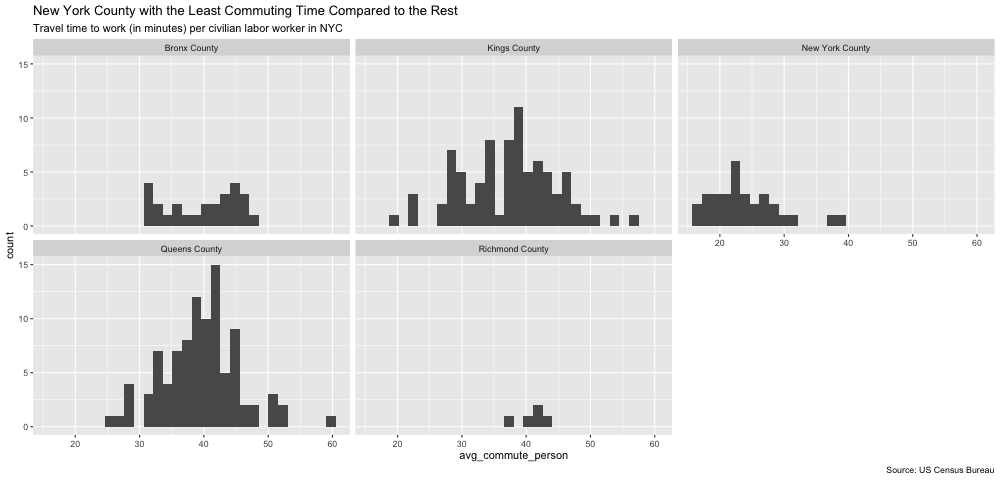

In [34]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=avg_commute_person) +
    geom_histogram() + 
    facet_wrap(~borough) +
  labs(
    title = "New York County with the Least Commuting Time Compared to the Rest",
    subtitle = "Travel time to work (in minutes) per civilian labor worker in NYC",
    caption = "Source: US Census Bureau"
  )

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2084 rows containing non-finite outside the scale range
(`stat_boxplot()`). 

R[write to console]: 2: Removed 2084 rows containing missing values or values outside the scale range
(`geom_point()`). 



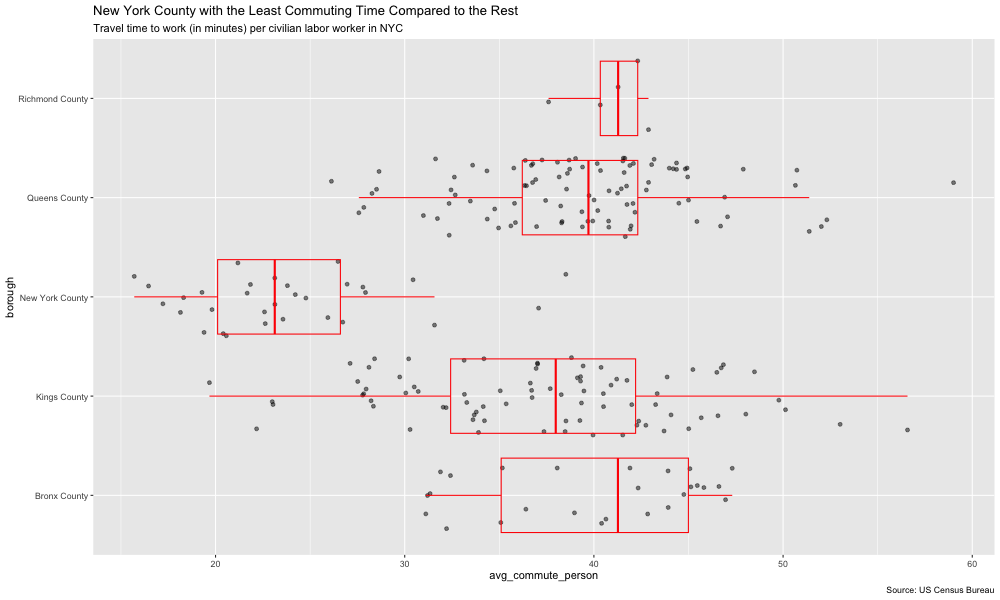

In [35]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=avg_commute_person, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") +
  labs(
    title = "New York County with the Least Commuting Time Compared to the Rest",
    subtitle = "Travel time to work (in minutes) per civilian labor worker in NYC",
    caption = "Source: US Census Bureau"
  )

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In [36]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = avg_commute_person)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  theme_minimal() +
  labs(
    title = "New York County with the Least Commuting Time Compared to the Rest",
    subtitle = "Travel time to work (in minutes) per civilian labor worker in NYC",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  ) 

# Save the map 
ggsave("nyc_commute_time_map.jpg", width = 10, height = 10, units = "in", dpi = 300)